# Initial Setup

Before beginning the assignment, we import the CIFAR dataset, and train a simple convolutional neural network (CNN) to classify it.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Load training and test data from the CIFAR10 dataset.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Define a simple CNN that classifies CIFAR images.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [ ]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

In [ ]:
train(net, trainloader)

[1,  2000] loss: 2.224
[1,  4000] loss: 1.890
[1,  6000] loss: 1.722
[1,  8000] loss: 1.633
[1, 10000] loss: 1.587
[1, 12000] loss: 1.506
[2,  2000] loss: 1.484
[2,  4000] loss: 1.420
[2,  6000] loss: 1.415
[2,  8000] loss: 1.361
[2, 10000] loss: 1.344
[2, 12000] loss: 1.339
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

In [ ]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 54.06%


In [ ]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

# Question 1: Visualize Weights

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

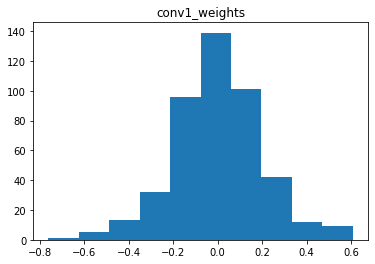

total range: [-0.760162, 0.607120]
3-sigma range: [-0.605496, 0.603754]


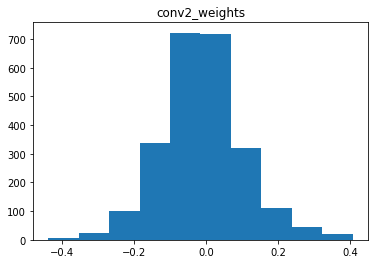

total range: [-0.436969, 0.407640]
3-sigma range: [-0.352082, 0.330516]


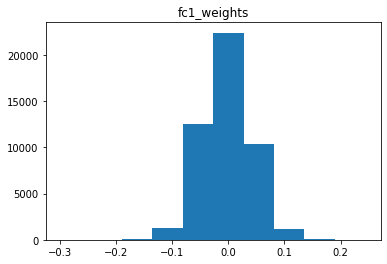

total range: [-0.297739, 0.243760]
3-sigma range: [-0.130031, 0.124764]


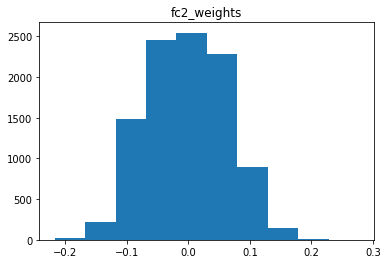

total range: [-0.216817, 0.277196]
3-sigma range: [-0.194549, 0.190645]


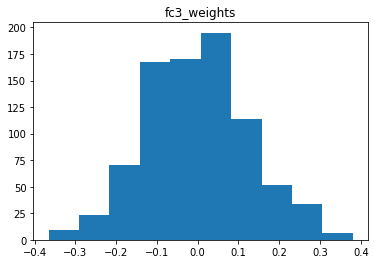

total range: [-0.365831, 0.380619]
3-sigma range: [-0.381832, 0.381906]


In [ ]:
# ADD YOUR CODE HERE to plot distributions of weights

# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)
conv1_weights = net.conv1.weight.data.cpu().view(-1)
conv2_weights = net.conv2.weight.data.cpu().view(-1)
fc1_weights = net.fc1.weight.data.cpu().view(-1)
fc2_weights = net.fc2.weight.data.cpu().view(-1)
fc3_weights = net.fc3.weight.data.cpu().view(-1)

dict = {'conv1_weights':conv1_weights, 'conv2_weights': conv2_weights, 'fc1_weights': fc1_weights, 'fc2_weights': fc2_weights, 'fc3_weights':fc3_weights}

# --------------------------------------------------------------------
# I print out the histogram of each weight.
# Besides, I also list the total range and 3-sigma range.
# --------------------------------------------------------------------
for name, weights in dict.items():
    plt.title(name)
    plt.hist(weights)
    plt.show()
    print('total range: [%f, %f]' %(weights.min(), weights.max()))
    print('3-sigma range: [%f, %f]' %(weights.mean()- 3*weights.std(), weights.mean()+ 3*weights.std()))

# Question 2: Quantize Weights

In [ ]:
net_q2 = copy_model(net)

In [ ]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    # ADD YOUR CODE HERE

    # --------------------------------------------------------------------
    # I choose symmetric quantization which is easier to use.
    # I have written 2 version of quantization using total range and 3-sigma range.
    # But I prefer to use total range.
    # Therefore, the float points will map to 8bit integer [-128, 127]
    # --------------------------------------------------------------------
    
    # total range version
    min_value = weights.min()
    max_value = weights.max()

    # 3-sigma range version
    # min_value = weights.mean()+ 3*weights.std()
    # max_value = weights.mean()- 3*weights.std()
    
    length = max(abs(min_value), abs(max_value))
    scale = 128/length 
    result = (weights * scale).round()
    return torch.clamp(result, min=-128, max=127), scale

In [ ]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [ ]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 54.03%


# Question 3: Visualize Activations

In [ ]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [ ]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

In [ ]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

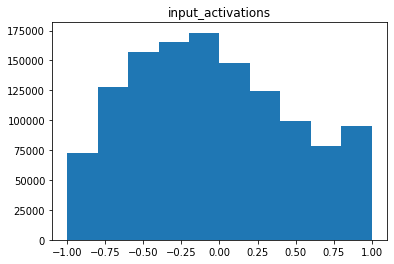

total range: [-1.000000, 1.000000]
3-sigma range: [-1.599783, 1.509372]


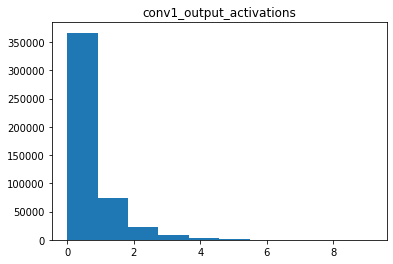

total range: [0.000000, 9.142660]
3-sigma range: [-1.848730, 2.936519]


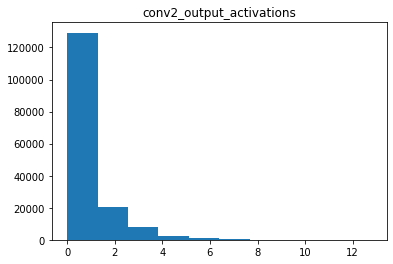

total range: [0.000000, 12.792068]
3-sigma range: [-2.702595, 4.011530]


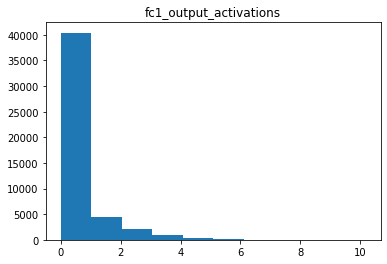

total range: [0.000000, 10.170301]
3-sigma range: [-2.411180, 3.307224]


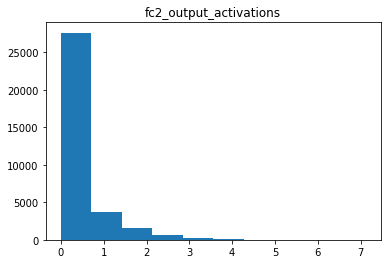

total range: [0.000000, 7.111728]
3-sigma range: [-1.633415, 2.331711]


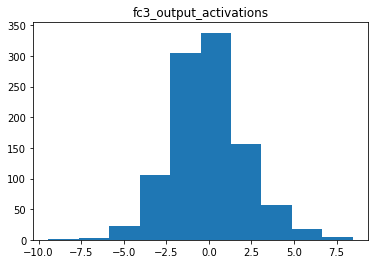

total range: [-9.425237, 8.454558]
3-sigma range: [-6.492058, 6.355117]


In [ ]:
# ADD YOUR CODE HERE to plot distributions of activations

# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:
#   input_activations
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations
#   fc2_output_activations
#   fc3_output_activations

# --------------------------------------------------------------------
# I use the same way as visual weights.
# input activation and fc3 output activation seems like normal distribution
# But other activations are not.
# Therefore, their 3-sigma range will not cover the actual range
# --------------------------------------------------------------------
dict = {'input_activations':input_activations, 'conv1_output_activations':conv1_output_activations, 'conv2_output_activations':conv2_output_activations, 'fc1_output_activations':fc1_output_activations, 'fc2_output_activations':fc2_output_activations, 'fc3_output_activations':fc3_output_activations}

for name, activations in dict.items():
    plt.title(name)
    plt.hist(activations)
    plt.show()
    print('total range: [%f, %f]' %(activations.min(), activations.max()))
    print('3-sigma range: [%f, %f]' %(activations.mean()- 3*activations.std(), activations.mean()+ 3*activations.std()))

# Question 4: Quantize Activations

In [ ]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        # --------------------------------------------------------------------
        # I use the the way in weights to quantize the input feature map.
        # Other layer input will not need to quantized because we will quantize the output.
        # --------------------------------------------------------------------
        min_value = pixels.min()
        max_value = pixels.max()
    
        length = max(abs(min_value), abs(max_value))
        scale = 128/length 
        return scale

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        
        # --------------------------------------------------------------------
        # The first layer output use the right hand side of the equation (3) in paper.
        # But we are easier to be confused by the left hand side of the equation.
        #
        # The output of other layer needs to multipy the weight scales and output scales of all previous layers.
        # --------------------------------------------------------------------

        value = activations * n_initial_input * n_w.data.cpu().numpy()
        for weights_scale, output_scale in ns:
            value *= weights_scale.data.cpu().numpy() * output_scale

        length = max(abs(value.min()), abs(value.max()))
        scale = 128 / length
        return scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp

        # ADD YOUR CODE HERE

        # --------------------------------------------------------------------
        # Quantize the input and output of the conv and FC to 8 bits.
        # Because relu and pooling can keep the value on 8 bits, 
        # we do not need to quantize their input and output.
        # --------------------------------------------------------------------

        x = torch.clamp((x * self.input_scale).round(), min=-128, max=127)
        x = self.conv1(x)
        x = torch.clamp((x * self.conv1.output_scale).round(), min=-128, max=127)
        x = self.pool(F.relu(x))
        
        x = self.conv2(x)
        x = torch.clamp((x * self.conv2.output_scale).round(), min=-128, max=127)
        x = self.pool(F.relu(x))

        x = x.view(-1, 16 * 5 * 5)

        x = self.fc1(x)
        x = torch.clamp((x * self.fc1.output_scale).round(), min=-128, max=127)
        x = F.relu(x)

        x = self.fc2(x)
        x = torch.clamp((x * self.fc2.output_scale).round(), min=-128, max=127)
        x = F.relu(x)

        x = self.fc3(x)
        x = torch.clamp((x * self.fc3.output_scale).round(), min=-128, max=127)

        return x

In [ ]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [ ]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 54.13%


# Question 5: Quantize Biases

In [ ]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

In [ ]:
train(net_with_bias, trainloader)

[1,  2000] loss: 2.191
[1,  4000] loss: 1.877
[1,  6000] loss: 1.691
[1,  8000] loss: 1.573
[1, 10000] loss: 1.516
[1, 12000] loss: 1.443
[2,  2000] loss: 1.380
[2,  4000] loss: 1.364
[2,  6000] loss: 1.327
[2,  8000] loss: 1.326
[2, 10000] loss: 1.288
[2, 12000] loss: 1.302
Finished Training


In [ ]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 54.61%


In [ ]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [ ]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 50.06%


In [ ]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)

        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )

        if (self.fc3.bias.data < -2147483648).any() or (self.fc3.bias.data > 2147483647).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        # ADD YOUR CODE HERE
        # --------------------------------------------------------------------
        # The quantization way are similar to quantize output activation
        # --------------------------------------------------------------------
        scale = n_initial_input * n_w.data.cpu().numpy()
        for weights_scale, output_scale in ns:
            scale *= weights_scale.data.cpu().numpy() * output_scale

        
        return torch.clamp((bias * scale).round(), min=-2147483648, max=2147483647)

In [ ]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [ ]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 54.71%


# Extract the input and output of the quantized model




In [ ]:
# copy the model with bias quantized model and save the weights
inference_model = copy_model(net_quantized_with_bias)
torch.save(inference_model.state_dict(), 'net_quantized_with_bias.pt')

In [ ]:
# Use accuray to make sure it is same model
score = test(inference_model, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 54.71%


Use an image as an input of the activations

In [ ]:
# random choose an image as the input and get the output
index = np.random.randint(0,10000)
input, label = trainset[index]
output = inference_model(input.unsqueeze(0).to(device))

Save the activations of input and output to csv

In [ ]:
import os 
import zipfile
# It is easier to download all the files with zip
zf = zipfile.ZipFile('parameters.zip', 'w', zipfile.ZIP_DEFLATED)

if not os.path.exists('./activations'):
    os.mkdir('./activations')

np.savetxt('./activations/input.csv', input.cpu().data.numpy().reshape(-1), delimiter=',')
np.savetxt('./activations/output.csv', output.cpu().data.numpy().reshape(-1), delimiter=',')
zf.write('./activations/input.csv')
zf.write('./activations/output.csv')

Save the weight of each layer to csv

In [ ]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')
    
for name, weights in inference_model.state_dict().items():
    print(name, 'with shape:' , weights.shape)
    np.savetxt('./weights/%s.csv' %(name) , weights.cpu().reshape(-1), delimiter=',')
    zf.write('./weights/%s.csv' %(name))

conv1.weight with shape: torch.Size([6, 3, 5, 5])
conv2.weight with shape: torch.Size([16, 6, 5, 5])
fc1.weight with shape: torch.Size([120, 400])
fc2.weight with shape: torch.Size([84, 120])
fc3.weight with shape: torch.Size([10, 84])
fc3.bias with shape: torch.Size([10])


Record the sacling factor to json file

In [ ]:
import json
scales = {'input_scale':inference_model.input_scale, 'conv1_output_scale': inference_model.conv1.output_scale, 'conv2_output_scale':inference_model.conv2.output_scale,
        'fc1_output_scale' :inference_model.fc1.output_scale, 'fc2_output_scale':inference_model.fc2.output_scale, 'fc3_output_scale':inference_model.fc3.output_scale}

with open('scale.json', 'w', newline='') as jsonfile:
    json.dump(scales, jsonfile)

zf.write('./scale.json')

save the zip file

In [ ]:
zf.close()
# Files are located on left bar.
# You can downlaod them.